In [1]:
!pip -q install transformers pillow matplotlib
!pip -q install timm

import torch, timm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import urllib.request
from transformers import AutoImageProcessor, AutoModelForImageClassification
device = "cuda" if torch.cuda.is_available() else "cpu"

#Part 1

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vitModel = timm.create_model("vit_tiny_patch16_224", pretrained=True).to(device)
vitModel.eval()
config = resolve_data_config({}, model=vitModel)
transform = create_transform(**config)
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/coco_sample.png"
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
x = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    logits = vitModel(x)
    top1 = logits.argmax(dim=-1).item()
labelsUrl = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(labelsUrl, "imagenet_classes.txt")
with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
print("Top 1 class name label name is:-", labels[top1])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Top 1 class name label name is:- tabby


#Part 2

In [3]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224" )
vitModel = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    attn_implementation="eager",
).to(device)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

### Part 2 (a)

In [4]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/coco_sample.png"
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
inputs = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    inputs = processor(images=img, return_tensors="pt").to(device)
    out = vitModel(**inputs, output_attentions=True, return_dict=True)
pred = out.logits.argmax(dim=-1).item()
attn = out.attentions[-1]
attn = attn[0]
clsToToken = attn[:, 0, 1:]
clsToPatches = clsToToken.mean(dim=0)
totalPatches = clsToPatches.shape[0]
gridSize = int(np.sqrt(totalPatches))
# assert grid_size * grid_size == num_patches, "Num patches not a perfect square?"
attnMap = clsToPatches.reshape(gridSize, gridSize).detach().cpu()
attnMap = (attnMap - attnMap.min()) / (attnMap.max() - attnMap.min() + 1e-8)
w, h = img.size
attnUp = F.interpolate(attnMap.unsqueeze(0).unsqueeze(0), size=(h, w), mode="bilinear", align_corners=False)
attnUp = attnUp.squeeze().numpy()

Top-1: Egyptian cat


### Part 2 (b)

In [7]:
print("number of layers:", len(out.attentions))
lastAtten = out.attentions[-1]
print("last layer shape:", tuple(lastAtten.shape))
B, H, S, S2 = lastAtten.shape
patch = vitModel.config.patch_size
imgSize = vitModel.config.image_size
totalPatchedExpected = (imgSize // patch) * (imgSize // patch)
print("patchSize:", patch, "imageSize:", imgSize)
print("TotalPatches:", totalPatchedExpected)
print("sequence Length S:", S, "S-1:", S - 1) #s-1 should match totalPatches+1
print("Confirming: sequenceLength = TotalPatches + 1 (CLS token is included)")

number of layers: 12
last layer shape: (1, 12, 197, 197)
patchSize: 16 imageSize: 224
TotalPatches: 196
sequence Length S: 197 S-1: 196
Confirming: sequenceLength = TotalPatches + 1 (CLS token is included)


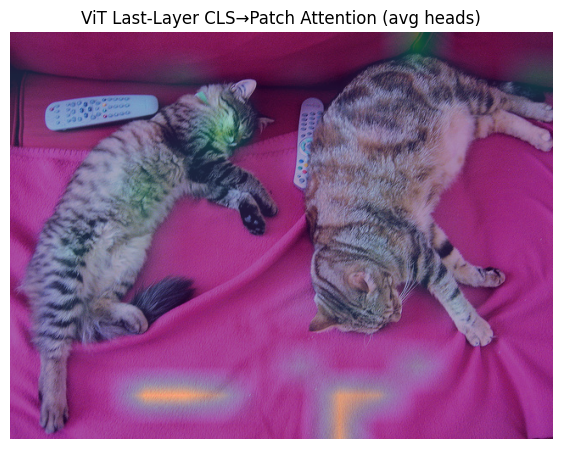

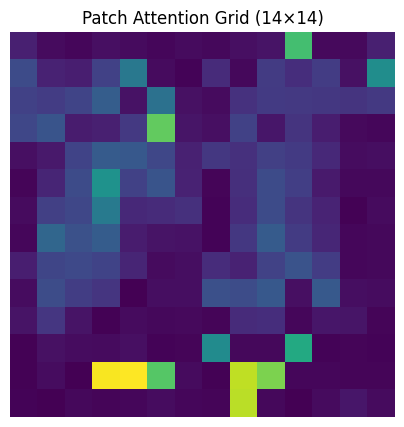

In [8]:
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.imshow(attnUp, alpha=0.45)
plt.axis("off")
plt.title("ViT Last-Layer CLS→Patch Attention (avg heads)")
plt.show()
plt.figure(figsize=(5, 5))
plt.imshow(attnMap, interpolation="nearest")
plt.axis("off")
plt.title("Patch Attention Grid (14×14)")
plt.show()

### Part 2 (c)

In [9]:
lastAtten.shape
aggregatedAtten = lastAtten.mean(dim=1)
clsAttention = aggregatedAtten[:, 0, :]
clsPatches = clsAttention[:, 1:]
print("End attention vector shape:", clsPatches.shape)

Final attention vector shape: torch.Size([1, 196])


### Part 2 (d)

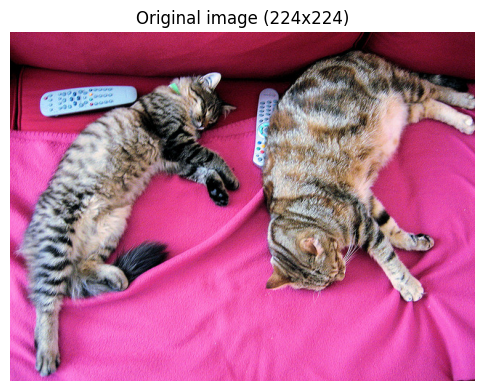

img_np shape: (480, 640, 3) dtype: uint8


In [16]:

img_np = np.array(img.convert("RGB"))

plt.figure(figsize=(6,6))
plt.imshow(img_np)
plt.axis("off")
plt.title("Original image (224x224)")
plt.show()

print("img_np shape:", img_np.shape, "dtype:", img_np.dtype)


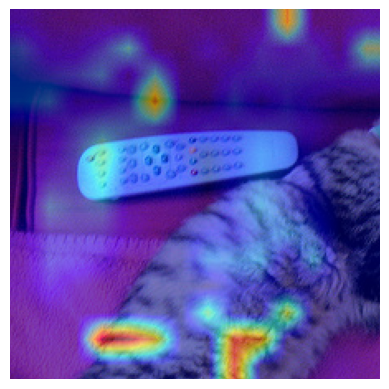

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image

model_name = 'google/vit-base-patch16-224'
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, attn_implementation="eager",
)
inputs = processor(images=img, return_tensors="pt").to(device)
image = img
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True, return_dict=True)
attentions = outputs.attentions[-1]
avg_attention = torch.mean(attentions, dim=1)
cls_attention = avg_attention[0, 0, 1:]
grid_size = int(np.sqrt(cls_attention.size(-1)))
mask = cls_attention.reshape(grid_size, grid_size).detach().numpy()

mask = (mask - mask.min()) / (mask.max() - mask.min())

plt.imshow(image)
plt.imshow(mask, cmap='jet', alpha=0.5, extent=(0, 224, 224, 0), interpolation='bilinear')
plt.axis('off')
plt.show()


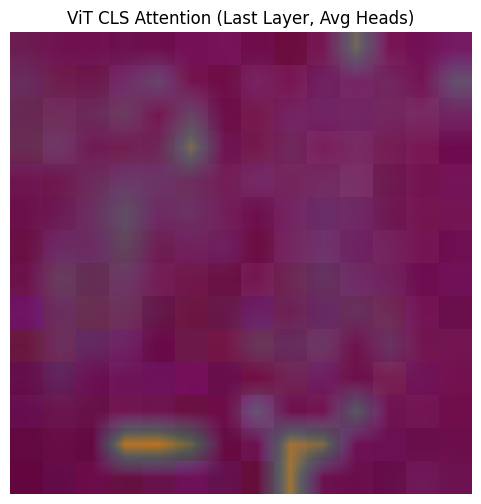

In [15]:
clsMap14x14 = clsPatches[0].reshape(14, 14)
attenLast = out.attentions[-1]
avgAtten = attenLast.mean(dim=1)
clsPatches = avgAtten[:, 0, 1:]
B = clsPatches.shape[0]
grid_size = 14
attnMap = clsPatches[0].reshape(grid_size, grid_size)  # (14, 14)
attnMap = attnMap - attnMap.min()
attnMap = attnMap / (attnMap.max() + 1e-8)
imgNp = np.array(img)
plt.figure(figsize=(6, 6))
plt.imshow(imgNp)
plt.imshow(attnMap.cpu().numpy(), alpha=0.45, interpolation="bilinear")
plt.axis("off")
plt.title("ViT CLS Attention (Last Layer, Avg Heads)")
plt.show()

In [ ]:
'''
Compare linear probes trained on the CLS token versus the mean of patch tokens. Which pooling method
performs better? Why? How might this choice interact with different pretraining objectives?
'''

### Part 3

### Part 4

### Part 5